# Overlay png image on folium and ipyleaflet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import folium
import ipyleaflet
from base64 import b64encode

vmin = 0
vmax = 2000

import matplotlib
cmap = matplotlib.cm.get_cmap("viridis")

# testing - not used here
import branca.colormap as cm
bcmap = cm.linear.viridis.scale(vmin=vmin, vmax=vmax).to_step(n=4)
bcmap.caption = 'my color scale'
bcmap


/tmp/ipykernel_182489/3982767682.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("viridis")


## Set up test data and save as png

[[1000. 2000. 2000. 2000. 2000.]
 [2000. 1000.    0.    0. 2000.]
 [2000.    0.   nan    0. 2000.]
 [2000.    0.    0. 1000. 2000.]
 [2000. 2000. 2000. 2000. 1000.]]


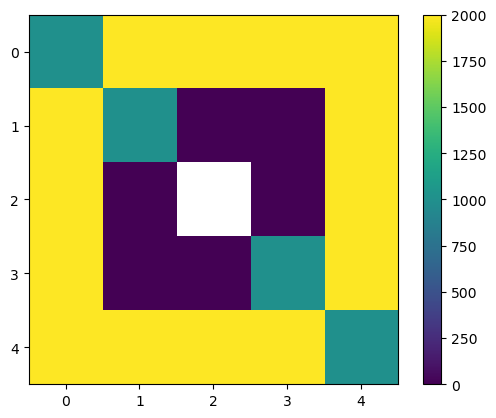

In [2]:
n = 5
data = np.zeros((n, n))

# borders are vmax
data[0, :] = vmax
data[-1, :] = vmax
data[:, 0] = vmax
data[:, -1] = vmax

# diagonal is vmax/2
for i in np.arange(n):
    data[i,i] = vmax/2

# central point is nan (see transparencu)
data[int(n/2),int(n/2)] = np.nan

print(data)

plt.imshow(data, cmap=cmap)
plt.colorbar()

In [3]:
# this still saves fig with border
# plt.imshow(data, cmap=cmap, aspect='equal', vmin=vmin, vmax=vmax)
# plt.axis('off')
# plt.savefig('temp.png', transparent=True, bbox_inches='tight', dpi=500)


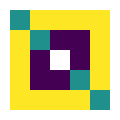

In [4]:
fig = plt.figure(figsize=(1, 1))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(data, cmap=cmap, aspect='equal', vmin=vmin, vmax=vmax)
fig.savefig('temp.png', dpi=500)

## Read png as base64

In [5]:
with open('temp.png', "rb") as f:
    data1 = b64encode(f.read())
    data1 = data1.decode("ascii")
    imgurl = "data:image/png;base64," + data1

In [6]:
# bottom left
x1,y1 = 175,-39

# bottom left
# x1,y1 = -5,39

x2,y2 = x1+n,y1+n
print(x1,x2,y1,y2)

bounds = [[y1, x1], [y2, x2]]
center = [(y1+y2)/2, (x1+x2)/2]
print(center)


175 180 -39 -34
[-36.5, 177.5]


## Get gridlines 

In [7]:
def get_latlon_gridlines(window=[-180,180,-90,90], dx=10,dy=10):
    x1,x2,y1,y2 = window
    gridlines = []
    # parallels for each lat
    for lat in np.arange(y1, y2+dy/2, dy):
        gridlines += [([lat,x1], [lat,x2])]
    # meridians for each lon
    for lon in  np.arange(x1, x2+dx/2, dx):
        gridlines += [([y1,lon], [y2,lon])]

    return(gridlines)

gridlines = get_latlon_gridlines(window=[x1,x2,y1,y2], dx=1,dy=1)

In [8]:
gridlines

[([np.float64(-39.0), 175], [np.float64(-39.0), 180]),
 ([np.float64(-38.0), 175], [np.float64(-38.0), 180]),
 ([np.float64(-37.0), 175], [np.float64(-37.0), 180]),
 ([np.float64(-36.0), 175], [np.float64(-36.0), 180]),
 ([np.float64(-35.0), 175], [np.float64(-35.0), 180]),
 ([np.float64(-34.0), 175], [np.float64(-34.0), 180]),
 ([-39, np.float64(175.0)], [-34, np.float64(175.0)]),
 ([-39, np.float64(176.0)], [-34, np.float64(176.0)]),
 ([-39, np.float64(177.0)], [-34, np.float64(177.0)]),
 ([-39, np.float64(178.0)], [-34, np.float64(178.0)]),
 ([-39, np.float64(179.0)], [-34, np.float64(179.0)]),
 ([-39, np.float64(180.0)], [-34, np.float64(180.0)])]

## Plot

### folium
- raw data ok but weird color scale
- png file and base64 are ok if png doesn't have border!

In [9]:
import os
curr_dir = os.getcwd()
curr_dir

'/home/rosa/git/rosatrancoso/notebook-share/docs/miscellaneous'


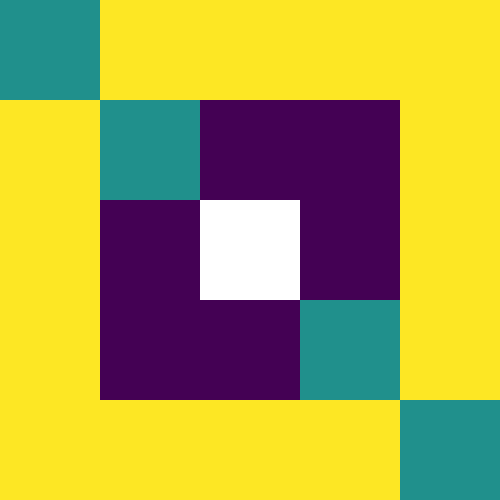
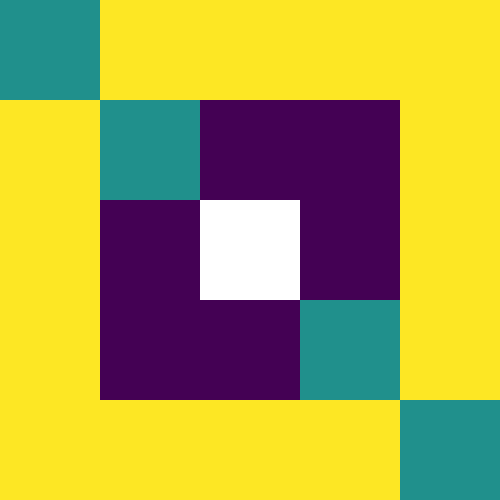

In [10]:
m = folium.Map(center, zoom_start=2)

folium.PolyLine(gridlines, color='gray', weight=0.5, name='gridlines').add_to(m)

folium.raster_layers.ImageOverlay(
    name='raw data',
    image=data,
    bounds=bounds,
    colormap=cmap,
    vmin=vmin, vmax=vmax,
    opacity=0.6,
).add_to(m)

folium.raster_layers.ImageOverlay(
    name='png file',
    image=os.path.join(curr_dir, 'temp.png'),
    bounds=bounds,
    opacity=0.6,
).add_to(m)

folium.raster_layers.ImageOverlay(
    name='png base64',
    image=imgurl,
    bounds=bounds,
    opacity=0.6,
).add_to(m)



m.add_child(folium.map.LayerControl(position='topleft', collapsed=False))
m.fit_bounds(m.get_bounds(),max_zoom=14)

# maybe we could do a colormap based on ColorLine
# folium.ColorLine(positions=[[70,-60],[70,0], [70,60]], colors=[0,1], colormap=['r','g'], weigth=10).add_to(m)

m

### ipyleaflet 
- doesn't plot raw data (np.array)
- png base64 is ok

In [11]:
m = ipyleaflet.Map(center=center, zoom=4)

m.add_layer(
    ipyleaflet.Polyline(
        locations=gridlines,
        color="gray" ,
        fill=False,
        weight=1
    )
)

# TraitError: The 'url' trait of an ImageOverlay instance expected a unicode string, not the ndarray array([[1000., 1000., 1000., ..., 2000., 2000., 2000.],
# m.add_layer(
#     ipyleaflet.ImageOverlay(
#         url=data,
#         bounds=bounds,
#         colormap=cmap
#     )
# )

m.add_layer(
    ipyleaflet.ImageOverlay(
        url=imgurl,
        bounds=bounds,
        colormap=cmap
    )
)

m

Map(center=[-36.5, 177.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…